In [1]:
# TODO: Clean up this implementation!
import datetime
print('Last updated:', datetime.datetime.now(), '(PT)')

Last updated: 2020-07-16 14:33:25.453289 (PT)


In [2]:
import functools
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
dtype = tf.float64

# Resources for learning TFP
# https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/NoUTurnSampler
# https://www.tensorflow.org/probability/overview
# https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc
# https://www.tensorflow.org/probability/examples/Modeling_with_JointDistribution
# https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model

# To better understand event_shape, batch_shape, sample_shape:
# https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Distribution
# https://www.youtube.com/watch?v=zWXTpZX4PPo

In [3]:
# Set random seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

In [4]:
# def stickbreak(v):
#     cumprod_one_minus_v = tf.math.cumprod(1 - v)
#     one_v = tf.pad(v, [[0, 1]], "CONSTANT", constant_values=1)
#     c_one = tf.pad(cumprod_one_minus_v, [[1, 0]], "CONSTANT", constant_values=1)
#     return one_v * c_one 
#
# Example:
# stickbreak(np.random.rand(3))

# Thanks to Dave Moore for extending this to work with batch dimensions!
def stickbreak(v):
    batch_ndims = len(v.shape) - 1
    cumprod_one_minus_v = tf.math.cumprod(1 - v)
    one_v = tf.pad(v, [[0, 0]] * batch_ndims + [[0, 1]], "CONSTANT", constant_values=1)
    c_one = tf.pad(cumprod_one_minus_v, [[0, 0]] * batch_ndims + [[1, 0]], "CONSTANT", constant_values=1)
    return one_v * c_one

# Example:
# stickbreak(np.random.rand(2, 3))  # Last dimension is the number of sticks breaks.
# Returns a tensor of shape(2, 4).

In [5]:
# See: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MixtureSameFamily
# See: https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model
def create_dp_sb_gmm(nobs, K, dtype=np.float64):
    return tfd.JointDistributionNamed(dict(
        # Mixture means
        mu = tfd.Independent(
            tfd.Normal(np.zeros(K, dtype), 3),
            reinterpreted_batch_ndims=1
        ),
        # Mixture scales
        sigma = tfd.Independent(
            tfd.Gamma(concentration=np.ones(K, dtype), rate=10),
            reinterpreted_batch_ndims=1
        ),
        # Mixture weights (stick-breaking construction)
        alpha = tfd.Gamma(concentration=np.float64(1.0), rate=10.0),
        v = lambda alpha: tfd.Independent(
            # tfd.Beta(np.ones(K - 1, dtype), alpha),
            # NOTE: Dave Moore suggests doing this instead, to ensure 
            # that a batch dimension in alpha doesn't conflict with 
            # the other parameters.
            tfd.Beta(np.ones(K - 1, dtype), alpha[..., tf.newaxis]),
            reinterpreted_batch_ndims=1
        ),
        # Alternatively,
        # v = tfd.Dirichlet(np.ones(K, dtype) / K),

        # Observations (likelihood)
        obs = lambda mu, sigma, v: tfd.Sample(tfd.MixtureSameFamily(
            # This will be marginalized over.
            mixture_distribution=tfd.Categorical(probs=stickbreak(v)),
            # mixture_distribution=tfd.Categorical(probs=v),
            components_distribution=tfd.Normal(mu, sigma)),
            sample_shape=nobs)
    ))

In [6]:
# Examples:
# print(dp_sb_gmm.resolve_graph())
# dp_sb_gmm = create_dp_sb_gmm(13, 5)
# sample = dp_sb_gmm.sample()
# dp_sb_gmm.log_prob(**sample)
# sample

In [7]:
# Example:
# dp_sb_gmm.log_prob(mu=tfd.Normal(np.float64(0), 1).sample(5),
#                    sigma=tfd.Uniform(np.float64(0), 1).sample(5),
#                    alpha=tf.cast(1, dtype),
#                    v=tfd.Beta(np.float64(1), 1).sample(5 - 1),
#                    obs=np.random.randn(1000))

In [8]:
# Read simulated data.
path_to_data = '../../data/sim-data/gmm-data-n200.json'
with open(path_to_data) as f:
    simdata = json.load(f)
    
y = np.array(simdata['y'], np.float64)

In [21]:
def plot_param_post(param, param_name, param_full_name, level=95, figsize=(12, 4), truth=None):
    plt.figure(figsize=figsize)
    
    ci_lower = (100 - level) / 2
    ci_upper = (100 + level) / 2

    plt.subplot(1, 2, 1)
    plt.boxplot(param, whis=[ci_lower, ci_upper], showmeans=True, showfliers=False)
    plt.xlabel('mixture components')
    plt.ylabel(param_full_name)
    plt.title('95% Credible Intervals for {}'.format(param_full_name))
    if truth is not None:
        for line in truth:
            plt.axhline(line, ls=':')

    plt.subplot(1, 2, 2)
    plt.plot(param);
    plt.xlabel('iterations')
    plt.ylabel(param_full_name)
    plt.title('Trace plot of {}'.format(param_full_name));

In [22]:
def plot_all_params(output):
    mu = output['mu'].numpy()
    sigma = output['sigma'].numpy()
    v = output['v']
    alpha = output['alpha'].numpy()
    eta = np.apply_along_axis(stickbreak, 1, v)
    
    plot_param_post(eta, 'eta', 'mixture weights', truth=simdata['w'])
    plot_param_post(mu, 'mu', 'mixture locations', truth=simdata['mu'])
    plot_param_post(sigma, 'sigma', 'mixture scales', truth=simdata['sig'])
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(alpha, bins=30, density=True);
    plt.xlabel("alpha")
    plt.ylabel("density")
    plt.title("Posterior distribution of alpha"); 
    
    plt.subplot(1, 2, 2)
    # Plot likelihood
    lp = [joint_log_prob(y, mu[i], sigma[i], alpha[i], v[i]) for i in range(len(mu))]
    lp = np.vstack(lp).ravel()
    plt.plot(lp)
    plt.xlabel("iteration (post-burn)")
    plt.ylabel("log likelihood");

In [9]:
%%time 

ncomponents = 10

print('Create model ...')
model = create_dp_sb_gmm(nobs=len(simdata['y']), K=ncomponents)

print('Define log joint density ...')
def joint_log_prob(obs, mu, sigma, alpha, v):
    return model.log_prob(obs=obs, 
                          mu=mu, sigma=sigma,
                          alpha=alpha, v=v)
    
# Test log joint density evaluation
# _ = joint_log_prob(y, 
#                    np.random.randn(10),
#                    np.random.rand(10),
#                    np.float64(1),
#                    np.random.rand(9))

# This is the same thing as:
# 
#     def unnormalized_posterior_log_prob(mu, sigma, alpha, v):
#         return joint_log_prob(y, mu, sigma, alpha, v)
# 
# where y is captured from the environment.
unnormalized_posterior_log_prob = functools.partial(joint_log_prob, y)

# Create initial state?
# Not sure though, because in ADVI, you can't directly initialize the parameters of interest;
# instead you should initialize the hyperparameters in the variational distributions.
# So, not sure if this does anything useful.
initial_state = [
    tf.zeros(ncomponents, dtype, name='mu'),
    tf.ones(ncomponents, dtype, name='sigma') * .1,
    tf.ones([], dtype, name='alpha'),
    tf.fill(ncomponents - 1, value=np.float64(0.5), name='v')
]

# Create bijectors to transform unconstrained to and from constrained parameters-space.
# For example, if X ~ Exponential(theta), then X is constrained to be positive. A transformation
# that puts X onto an unconstrained space is Y = log(X). In that case, the bijector used
# should be the **inverse-transform**, which is exp(.) (i.e. so that X = exp(Y)).

# Define the inverse-transforms for each parameter in sequence.
bijectors = [
    tfb.Identity(),  # mu
    tfb.Exp(),  # sigma
    tfb.Exp(),  # alpha
    tfb.Sigmoid()  # v
]

   
print('Define sampler ...')
@tf.function(autograph=False)
def sample(use_nuts, max_tree_depth=10):
    if use_nuts:
        ### NUTS ###
        kernel = tfp.mcmc.SimpleStepSizeAdaptation(
            tfp.mcmc.TransformedTransitionKernel(
                inner_kernel=tfp.mcmc.NoUTurnSampler(
                     target_log_prob_fn=unnormalized_posterior_log_prob,
                     max_tree_depth=max_tree_depth, step_size=0.1, seed=1),
                bijector=bijectors),
            num_adaptation_steps=400,  # should be smaller than burn-in.
            target_accept_prob=0.8)
        trace_fn = lambda _, pkr: pkr.inner_results.inner_results.is_accepted
    else:
        ### HMC ###
        kernel = tfp.mcmc.SimpleStepSizeAdaptation(
            tfp.mcmc.TransformedTransitionKernel(
                inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn=unnormalized_posterior_log_prob,
                    step_size=0.01, num_leapfrog_steps=100, seed=1),
                bijector=bijectors),
            num_adaptation_steps=400)  # should be smaller than burn-in.
        trace_fn = lambda _, pkr: pkr.inner_results.inner_results.is_accepted

    return tfp.mcmc.sample_chain(
        num_results=500,
        num_burnin_steps=500,
        current_state=initial_state,
        kernel=kernel,
        trace_fn=trace_fn)

Create model ...
Define log joint density ...
Define sampler ...
CPU times: user 16.4 ms, sys: 3.11 ms, total: 19.5 ms
Wall time: 37.1 ms


In [13]:
%%time
# FIXME: ADVI is not working in TFP.
# ADVI
# tfp.vi.monte_carlo_variational_loss?

qmu_loc = tf.Variable(tf.random.normal([ncomponents], dtype=np.float64), name='qmu_loc')
qmu_rho = tf.Variable(tf.random.normal([ncomponents], dtype=np.float64), name='qmu_rho')

qsigma_loc = tf.Variable(tf.random.normal([ncomponents], dtype=np.float64) - 1, name='qsigma_loc')
qsigma_rho = tf.Variable(tf.random.normal([ncomponents], dtype=np.float64), name='qsigma_rho')

qv_loc = tf.Variable(tf.random.normal([ncomponents - 1], dtype=np.float64), name='qv_loc')
qv_rho = tf.Variable(tf.random.normal([ncomponents - 1], dtype=np.float64), name='qv_rho')

qalpha_loc = tf.Variable(tf.random.normal([], dtype=np.float64), name='qalpha_loc')
qalpha_rho = tf.Variable(tf.random.normal([], dtype=np.float64), name='qalpha_rho')

surrogate_posterior = tfd.JointDistributionNamed(dict(
    # qmu
    mu=tfd.Independent(tfd.Normal(qmu_loc, tf.nn.softplus(qmu_rho)), reinterpreted_batch_ndims=1),
    # qsigma
    sigma=tfd.Independent(tfd.LogNormal(qsigma_loc, tf.nn.softplus(qsigma_rho)), reinterpreted_batch_ndims=1),
    # qv
    v=tfd.Independent(tfd.LogitNormal(qv_loc, tf.nn.softplus(qv_rho)), reinterpreted_batch_ndims=1),
    # qalpha
    alpha=tfd.LogNormal(qalpha_loc, tf.nn.softplus(qalpha_rho))))

free_params = [qmu_loc, qmu_rho,
               qsigma_loc, qsigma_rho,
               qv_loc, qv_rho,
               qalpha_loc, qalpha_rho]
  
y = np.array(simdata['y'], dtype=np.float64)

# Simplication of the commented model_log_prob below.
# Provided by David Moore.
model_log_prob = functools.partial(model.log_prob, obs=y)
# def model_log_prob(**q_samples):
#     d = q_samples
#     d['obs'] = y
#     return model.log_prob(d)

# s = surrogate_posterior.sample(3)
# model_log_prob(**s)

# FIXME?!
losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model_log_prob,
    surrogate_posterior=surrogate_posterior,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),  # David Moore: 0.1
    sample_size=100,  # David Moore
    num_steps=2000)

CPU times: user 27.8 s, sys: 1.95 s, total: 29.7 s
Wall time: 11.6 s


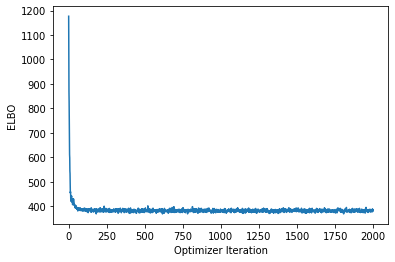

In [18]:
plt.plot(losses.numpy())
plt.xlabel('Optimizer Iteration')
plt.ylabel('ELBO');

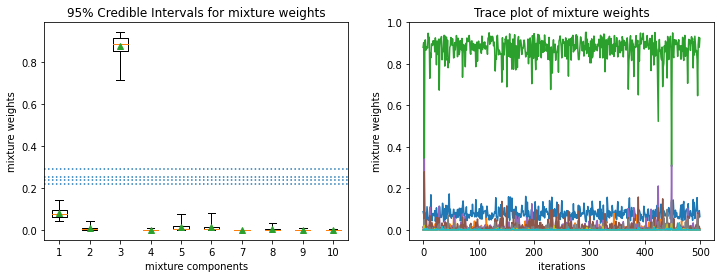

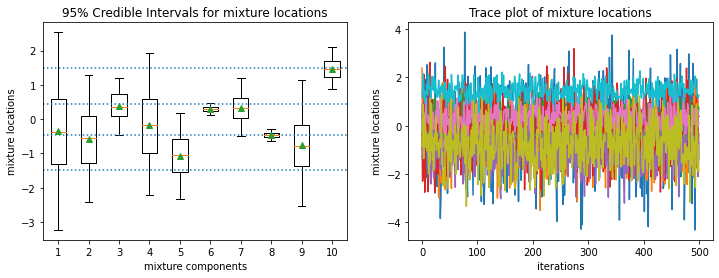

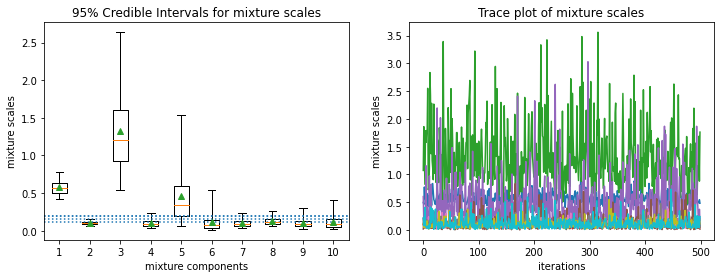

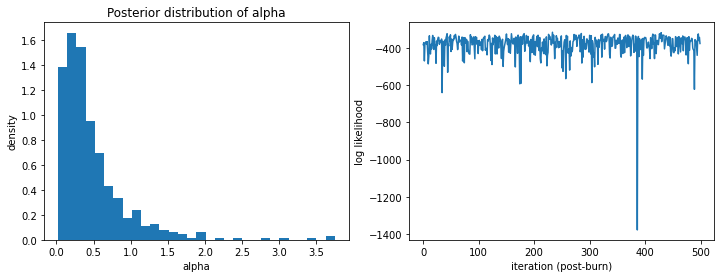

In [24]:
# Extract posterior samples from VI
advi_output = surrogate_posterior.sample(500)
plot_all_params(advi_output)

In [ ]:
print('Run HMC samplers ...')
%time [mu, sigma, alpha, v], is_accepted = sample(use_nuts=False)  # 53 seconds.
hmc_output = dict(mu=mu, sigma=sigma, alpha=alpha, v=v, acceptance_rate=is_accepted.numpy().mean())

Run HMC samplers ...


In [13]:
print('Run NUTS samplers ...')
%time [mu, sigma, alpha, v], is_accepted = sample(use_nuts=True)  # 9min 15s
nuts_output = dict(mu=mu, sigma=sigma, alpha=alpha, v=v, acceptance_rate=is_accepted.numpy().mean())

Run NUTS samplers ...
CPU times: user 16min 58s, sys: 2min 4s, total: 19min 2s
Wall time: 8min 19s


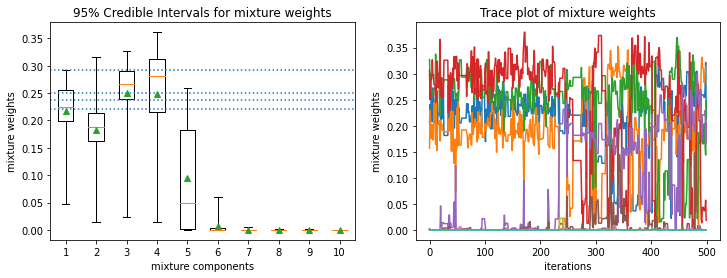

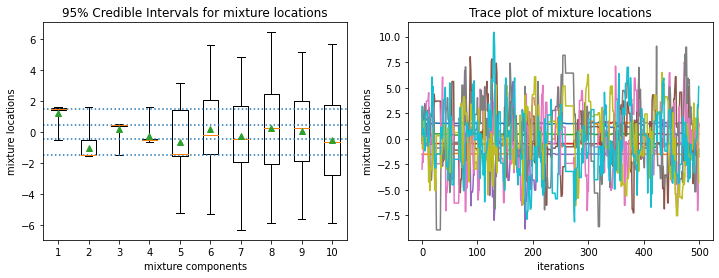

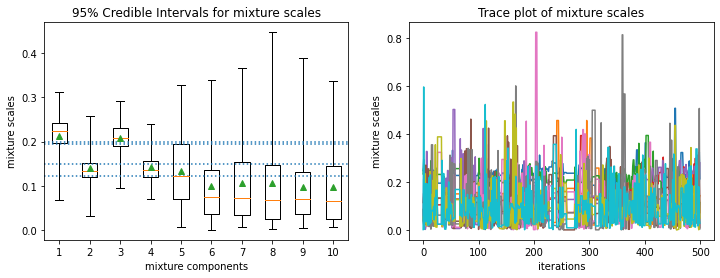

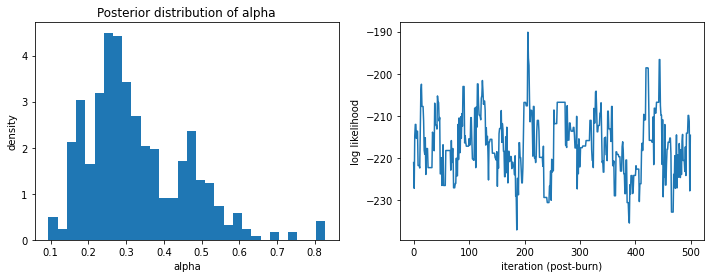

In [16]:
# HMC posterior inference
plot_all_params(hmc_output)

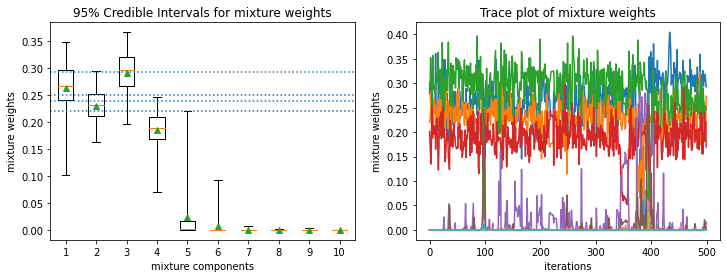

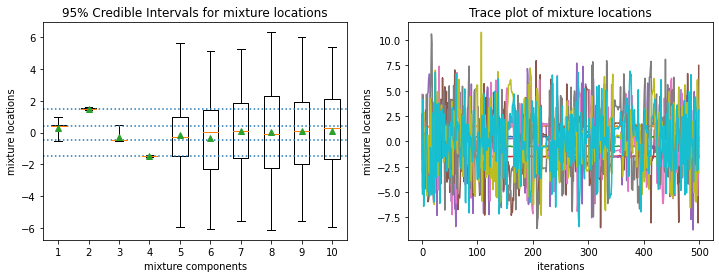

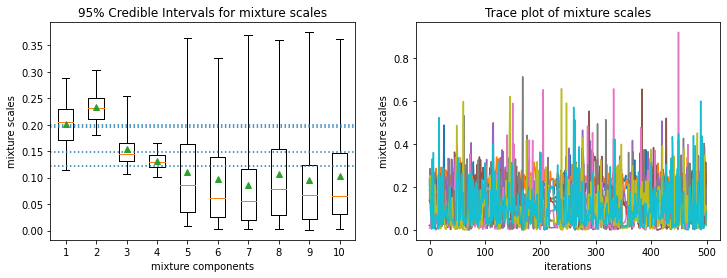

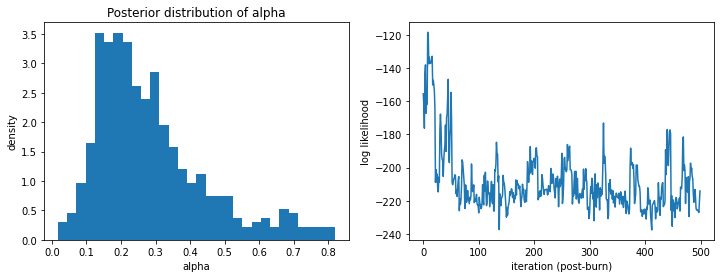

In [17]:
# NUTS posterior inference
plot_all_params(nuts_output)